## To-do Functions:
- Read fasta file.     x
- Read a directory with fasta files     x
- Extract sequence and head.    x
- recognize different types of information from the file.     x
- Make graph.    x
- Create new text file and write seqs and the different relations into it.  x

In [1]:
%matplotlib inline
import os, sys
import subprocess as sp
from itertools import cycle
import networkx as nx
import re
import ntpath
from eden.util import display

In [2]:
"""read a fasta file separate the head and the sequence"""
def _readFastaFile(file_path =None):
    head_mark0 = '#'
    head_mark1 = '='
    head_mark2 = 'G'
    head_mark3 = 'C'
    head_list = []
    sequence_list = []  
    
    #""" for file in os.listdir(path): #open file """
    read_file = open(file_path ,'r') 
    #print file_path
    
    for line in read_file:
        
        lines = list(line)
            # the read line is the head of the sequence write it in head list
        if lines[0] == head_mark0 and lines[1] == head_mark1 and lines[2] == head_mark2 and lines[3] == head_mark3:
            #print ('read line',line)
            line = line.strip('#=GC ')            
            line = line.strip('\n')
            line = line.split(' ')
            line = filter(None, line)
            #print ('line',line)

            head = line[0]
            head_list.append(head)
            #print ('head_list', head_list)
            sequence = line[1].split()
            sequence_list.append(sequence)
            #print ('seq_list', sequence_list)
            zip_head_seqs = zip(head_list, sequence_list)
      
    return zip_head_seqs

In [3]:
"""Recognize the different types of information (cons, sscons, consSS, entropy, cov)"""
def _identifyInformationType(file_name, head_seq_list):

    secondery_structure_s = []
    conservation_s = []
    conservation_stringth_s = []
    entropy_0_s = []
    entropy_1_s = []
    entropy_2_s = []
    entropy_3_s = []
    coveration_s = []

    for i, elemant in enumerate(head_seq_list):
        #print elemant
        #print i
        #print ('head_seq_list[i]', head_seq_list[i])
        info_item = head_seq_list[i]
        
        if info_item[0] == 'SS_cons':
            secondery_structure_s.append(str(info_item[1]))
            #print ('secondery_structure_s', secondery_structure_s)
            
        if info_item[0] == 'cons':
            conservation_s.append(str(info_item[1]))
            #print ('conservation', conservation_s)
            
        if info_item[0] == 'consSS':
            conservation_stringth_s.append(info_item[1])
            #print ('conservation_stringth_s', conservation_stringth_s)
            
        if info_item[0] == 'col_entropy_0':
            entropy_0_s.append(info_item[1])
            #print ('entropy_0_s', entropy_0_s)
            
        if info_item[0] == 'col_entropy_1':
            entropy_1_s.append(info_item[1])
            #print ('entropy_1_s', entropy_1_s)

        if info_item[0] == 'col_entropy_2':
            entropy_2_s.append(info_item[1])
            #print ('entropy_2_s', entropy_2_s)
            
        if info_item[0] == 'col_entropy_3':
            entropy_3_s.append(info_item[1])
            #print ('entropy_3_s', entropy_3_s)    
            
        if info_item[0] == 'cov_SS_cons':
            #print('head_seq_list[1]', head_seq_list[1])
            coveration_s.append(info_item[1])
            #print ('coveration_s', coveration_s)
    #print '#########'
    zip_head_seq_struc = zip(conservation_s, secondery_structure_s)
    #print zip_head_seq_struc
    return zip_head_seq_struc

In [4]:
"""Writ seq file as t \n v or V info \n e v1v2\n"""
def _writeGraphFile(file_path, info_type, struc):
    
    next_relation = 'next'
    #basepair_relation = 'bp'
    
    dir_name = ntpath.dirname(file_path)
    new_file_name = ntpath.splitext( ntpath.basename(file_path))[0]
    new_file_name = dir_name + "/" + new_file_name + "." + "seq"
    #print new_file_name 
    new_file = open(ntpath.join(file_path, new_file_name), 'w+')
    new_file.write('t\n')
    
    info_types = list(info_type)
    for i, info in enumerate(info_types):
        new_file.write('V' + ' ' + str(i) + ' ' + info + '\n')
        if i != 0:
            j = i-1
            new_file.write('e' + ' ' + str(j) + ' ' + str(i) + ' ' + next_relation + '\n')
    basepair_relation = _identifyBasepair(new_file, struc)
    new_file.close()
    

In [5]:
'''Recognize basepairs'''
def _identifyBasepair(new_file, struc):
    
    open_pran = "<"
    close_pran = ">"
    basepair_relation = 'bp'
    stack_o = []
    stack_c = []

    #seq_struc_zip = zip(seq, struc)
    for i, k in enumerate(struc):           
        """find basepair and connect them"""
        if struc[i] == open_pran:
            j = i
            stack_o.append(struc[j])
            #print ('struc[i]', struc[j])
            open_len = len(stack_o)
            #print ('open_len', open_len)

        if struc[i] == close_pran:
            stack_c.append(struc[i])
            stack_o.pop()
            new_file.write('e' + ' ' + str(j) + ' ' + str(i) + ' ' + basepair_relation + '\n')
            j = j-1

    #return G 

In [6]:
'''Recognize basepairs and include them to the generated graph'''
def _makeGraph(head, seq, struc):
    
    print ("Graph title", head)
    open_pran = "<" or "(" or "[" or "{"
    close_pran = ">" or ")" or "]" or "}"
    stack_o = []
    stack_c = []
    G = nx.Graph()

    seq_struc_zip = zip(seq, struc)

    for i, k in enumerate(struc):
        G.add_node(i, label = seq[i])
        # connect with the next node 
        if i > 0:
            G.add_edge(i-1, i, label= 'x')
           
        """find basepair and connect them"""
        if struc[i] == open_pran:
            j = i
            stack_o.append(struc[j])
            open_len = len(stack_o)

        if struc[i] == close_pran:
            stack_c.append(struc[i])
            stack_o.pop()
            G.add_edge(i, j, label = 'b')
            j = j-1

    return G 

## Experiments:

In [7]:
def _readFileGraphGenerating(file_path=None):
    file_name = ntpath.basename(file_path)
    head = file_name
    zip_head_seqs = _readFastaFile(file_path)
    #print ('zip_head_seqs', zip_head_seqs)
    #print '**************'
    info_type = _identifyInformationType(head, zip_head_seqs)
    for i, item in enumerate(info_type):   
        #print ('zip', info_type)
        seq = item[0].strip('[\']')
        print ('seq', seq)
        struc = item[1].strip('[\']')
        print ('stru', struc)
        write_file = _writeGraphFile(file_path, seq, struc)
        G = _makeGraph(head, seq, struc)
        display.draw_graph(G, node_size=180, font_size=9, node_border=True, prog='neato')

## Read one file

('seq', 'nnCC-nGn-CCGGGCCCCUCUGGCAGYnC--n--Ann--GnRCUGYGAUGUCGGA-YUGGnn')
('stru', '<<<<.<<-.<<<<---------<<<<<<<.._.._._..>>>>>>>---->>>>-.>>>>>>')
('i', 0)
('j', 0)
('i', 1)
('j', 1)
('i', 2)
('j', 2)
('i', 3)
('j', 3)
('i', 5)
('j', 5)
('i', 6)
('j', 6)
('i', 9)
('j', 9)
('i', 10)
('j', 10)
('i', 11)
('j', 11)
('i', 12)
('j', 12)
('i', 22)
('j', 22)
('i', 23)
('j', 23)
('i', 24)
('j', 24)
('i', 25)
('j', 25)
('i', 26)
('j', 26)
('i', 27)
('j', 27)
('i', 28)
('j', 28)
('Graph title', '550-53949-1-0.sto')


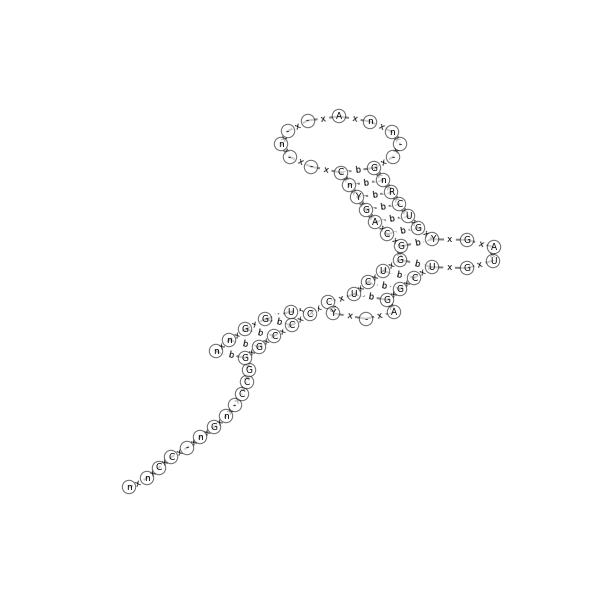

In [8]:
file_path = "/home/alsheikm/GitDir/EeDN_work/StoExamples/StoExmapleSmall/positives-sto/550-53949-1-0.sto"
File_to_Graph = _readFileGraphGenerating(file_path)

## Read a directory

In [ ]:
"""read a fasta file separate the head and the sequence"""
def _readFastaDir(file_path):
    head_mark0 = '#'
    head_mark1 = '='
    head_mark2 = 'G'
    head_mark3 = 'C'
    head_list = []
    sequence_list = []  
    
    #print 'in reading'
    
    #""" for file in os.listdir(path): #open file """
    #read_file = open(os.path.join( folder_name, file_name) ,'r')
    read_file = open(file_path ,'r')    
    for line in read_file:
        lines = list(line)
            # the read line is the head of the sequence write it in head list
        if lines[0] == head_mark0 and lines[1] == head_mark1 and lines[2] == head_mark2 and lines[3] == head_mark3:
            #print ('read line',line)
            line = line.strip('#=GC ')            
            line = line.strip('\n')
            line = line.split(' ')
            line = filter(None, line)
            #print ('line',line)
            
            head = line[0]
            head_list.append(head)
            #print ('head_list', head_list)
            sequence = line[1].split()
            sequence_list.append(sequence)
            #print ('seq_list', sequence_list)
            zip_head_seqs = zip(head_list, sequence_list)
      
    return zip_head_seqs

In [ ]:
#directory = "/home/alsheikm/GitDir/EeDN_work/StoExamples/StoExmapleSmall"
def _readFolderGraphGenerating(directory = None):
    for file_path in os.listdir(directory):
        print file_path
        folder_path = os.path.join( directory, file_path)
        #print folder_path
        for file_name in os.listdir(folder_path):
            '''test that the file has the sto extension'''
            file_extention = os.path.splitext(file_name)[-1].lower()
            #print file_extention
            if file_extention == '.sto': 
                #print file_name
                #print folder_name
                head = file_name
                #print file_complete_path
                file_complete_path = os.path.join( folder_path, file_name)
                #print file_complete_path
                zip_head_seqs = _readFastaDir(file_complete_path)
                #print ('zip_head_seqs', zip_head_seqs)
                info_type = _identifyInformationType(head, zip_head_seqs)
                for i, item in enumerate(info_type):   
                    #print ('zip', info_type)
                    seq = item[0].strip('[\']')
                    print ('seq', seq)
                    struc = item[1].strip('[\']')
                    print ('stru', struc)
                    #file_complete_path = ntpath.join(folder_path, file_name)
                    write_file = _writeGraphFile(file_complete_path, seq)
                    G = _makeGraph(head, seq, struc)
                    display.draw_graph(G, node_size=180, font_size=9, node_border=True, prog='neato')

In [ ]:
directory = "/home/alsheikm/GitDir/EeDN_work/StoExamples/StoExmapleSmall"
Folder_to_Graph = _readFolderGraphGenerating(directory)